# 01. Data Validation

**Purpose:** Validate data coverage, frequency, completeness, and basic quality checks.

**Datasets used:**
- `01_Data/Daily Rates(in).csv` — Bank of Canada interest rates (raw)
- `03_Results/housing_data_with_features.csv` — Processed housing data with engineered features

**Note:** The feature-engineered dataset is used for housing validation as it contains
the merged and cleaned data from the original MLS Home Price Index source.

> ⚠️ **Kernel Notice**
>
> This notebook must be run using the **Python (Housing)** kernel.
>
> If prompted when opening the notebook:
> - Select **Python (Housing)**
> - Click **Select**
> - Then run all cells in order

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print('✓ Libraries imported successfully!')

✓ Libraries imported successfully!


## 1. Load Datasets

In [14]:
# Load raw interest rates
rates_df = pd.read_csv('../01_Data/Daily Rates(in).csv')
rates_df['Date'] = pd.to_datetime(rates_df['Date'])

# Load processed housing data (Composite house type only, merged with rates)
housing_df = pd.read_csv('../03_Results/housing_data_with_features.csv')
housing_df['Date'] = pd.to_datetime(housing_df['Date'])

print('✓ Datasets loaded!')
print(f'  Rates   : {rates_df.shape[0]:,} rows × {rates_df.shape[1]} columns')
print(f'  Housing : {housing_df.shape[0]:,} rows × {housing_df.shape[1]} columns')

✓ Datasets loaded!
  Rates   : 7,670 rows × 6 columns
  Housing : 1,260 rows × 22 columns


## 2. Column Names & Data Types

In [15]:
print('RATES DataFrame')
print('=' * 50)
print(rates_df.dtypes)
print('\nSample:')
print(rates_df.head(3))

print()
print('HOUSING DataFrame')
print('=' * 50)
print(housing_df.dtypes)
print('\nSample:')
print(housing_df.head(3))

RATES DataFrame
Date           datetime64[ns]
Mortgage_1Y           float64
Mortgage_3Y           float64
Mortgage_5Y           float64
Prime_Rate            float64
Policy_Rate           float64
dtype: object

Sample:
        Date  Mortgage_1Y  Mortgage_3Y  Mortgage_5Y  Prime_Rate  Policy_Rate
0 2005-01-01         4.25          4.8          5.6        6.05          NaN
1 2005-01-02         4.25          4.8          5.6        6.05          NaN
2 2005-01-03         4.25          4.8          5.6        6.05          NaN

HOUSING DataFrame
Date                  datetime64[ns]
City                          object
Price                          int64
Index                        float64
Mortgage_1Y                  float64
Mortgage_3Y                  float64
Mortgage_5Y                  float64
Prime_Rate                   float64
Policy_Rate                  float64
Index_Lag1                   float64
Index_Lag3                   float64
Index_Lag12                  float64
Index_MoM_

## 3. Date Range Validation

In [16]:
print('DATE RANGE CHECK')
print('=' * 50)
print(f'Rates   : {rates_df["Date"].min().date()}  →  {rates_df["Date"].max().date()}')
print(f'Housing : {housing_df["Date"].min().date()}  →  {housing_df["Date"].max().date()}')

years = housing_df['Date'].dt.year.nunique()
print(f'\n✓ Coverage: {years} years ({housing_df["Date"].dt.year.min()} - {housing_df["Date"].dt.year.max()})')

# Check alignment
if rates_df['Date'].min().year == housing_df['Date'].min().year:
    print('✓ Both datasets start in the same year')
if abs((rates_df['Date'].max() - housing_df['Date'].max()).days) < 100:
    print('✓ Both datasets end in similar period')

DATE RANGE CHECK
Rates   : 2005-01-01  →  2025-12-31
Housing : 2005-01-01  →  2025-12-01

✓ Coverage: 21 years (2005 - 2025)
✓ Both datasets start in the same year
✓ Both datasets end in similar period


## 4. Missing Values Check

In [17]:
# ============================================================
# RATES: Check before treatment
# ============================================================
print('MISSING VALUES - RATES (before treatment)')
print('=' * 50)
for col, count in rates_df.isnull().sum().items():
    pct = count / len(rates_df) * 100
    if col == 'Policy_Rate':
        print(f'  △ {col}: {count} missing ({pct:.1f}%) ← see treatment below')
    else:
        icon = '✓' if count == 0 else '⚠'
        print(f'  {icon} {col}: {count} missing ({pct:.1f}%)')

# ============================================================
# Policy_Rate Treatment: Forward Fill
# ============================================================
print()
print('POLICY_RATE TREATMENT')
print('=' * 50)
print()
print('  Why 52.8% missing?')
print('  → Bank of Canada announces Policy Rate only 8 times/year')
print('  → On non-announcement days there is no new rate (not a data error)')
print()
print('  Solution: Forward Fill (ffill)')
print('  → Each non-announcement day inherits the most recent announced rate')
print('  → This matches real-world behaviour: rate stays the same until next announcement')
print()

rates_df = rates_df.sort_values('Date').reset_index(drop=True)
before = rates_df['Policy_Rate'].isnull().sum()
rates_df['Policy_Rate'] = rates_df['Policy_Rate'].ffill().bfill()
after  = rates_df['Policy_Rate'].isnull().sum()

print(f'  Before ffill : {before} missing')
print(f'  After  ffill : {after}  missing')
if after == 0:
    print('  ✓ Policy_Rate fully imputed via forward fill')
else:
    print(f'  ⚠ {after} rows still missing (likely at very start of dataset — no prior rate to fill from)')
    # Fill any remaining NaN at the very start with the first valid value
    rates_df['Policy_Rate'] = rates_df['Policy_Rate'].bfill()
    print(f'  ✓ Remaining {after} rows filled with backward fill (start of series)')

print()
print('  Sample Policy_Rate after treatment:')
print(rates_df[['Date','Policy_Rate']].head(10).to_string(index=False))

# ============================================================
# RATES: Check after treatment
# ============================================================
print()
print('MISSING VALUES - RATES (after treatment)')
print('=' * 50)
for col, count in rates_df.isnull().sum().items():
    icon = '✓' if count == 0 else '⚠'
    pct  = count / len(rates_df) * 100
    print(f'  {icon} {col}: {count} missing ({pct:.1f}%)')

# ============================================================
# HOUSING: Missing values check
# ============================================================
print()
print('MISSING VALUES - HOUSING')
print('=' * 50)

core_cols = ['Date', 'City', 'Price', 'Index',
             'Mortgage_1Y', 'Mortgage_3Y', 'Mortgage_5Y', 'Prime_Rate', 'Policy_Rate']

print('  Core columns (must be complete):')
for col in core_cols:
    count = housing_df[col].isnull().sum()
    icon  = '✓' if count == 0 else '❌'
    print(f'    {icon} {col}: {count} missing')

eng_cols = [c for c in housing_df.columns if c not in core_cols + ['Policy_Rate']]
print('\n  Engineered features (small gaps at start = expected):')
for col in eng_cols:
    count = housing_df[col].isnull().sum()
    icon  = '✓' if count <= 60 else '⚠'
    print(f'    {icon} {col}: {count} missing')

print()
print('  Note: Lag1=5, Lag3=15, Lag12=60 missing rows are at the START')
print('  of each city series — mathematically unavoidable and expected.')

MISSING VALUES - RATES (before treatment)
  ✓ Date: 0 missing (0.0%)
  ✓ Mortgage_1Y: 0 missing (0.0%)
  ✓ Mortgage_3Y: 0 missing (0.0%)
  ✓ Mortgage_5Y: 0 missing (0.0%)
  ✓ Prime_Rate: 0 missing (0.0%)
  △ Policy_Rate: 4052 missing (52.8%) ← see treatment below

POLICY_RATE TREATMENT

  Why 52.8% missing?
  → Bank of Canada announces Policy Rate only 8 times/year
  → On non-announcement days there is no new rate (not a data error)

  Solution: Forward Fill (ffill)
  → Each non-announcement day inherits the most recent announced rate
  → This matches real-world behaviour: rate stays the same until next announcement

  Before ffill : 4052 missing
  After  ffill : 0  missing
  ✓ Policy_Rate fully imputed via forward fill

  Sample Policy_Rate after treatment:
      Date  Policy_Rate
2005-01-01          0.5
2005-01-02          0.5
2005-01-03          0.5
2005-01-04          0.5
2005-01-05          0.5
2005-01-06          0.5
2005-01-07          0.5
2005-01-08          0.5
2005-01-09     

## 5. City & Coverage

In [18]:
print('CITY COVERAGE')
print('=' * 50)
city_counts = housing_df['City'].value_counts()
print(f'\nTotal cities: {housing_df["City"].nunique()}')
for city, count in city_counts.items():
    print(f'  ✓ {city}: {count} records')

print()
print('RECORDS PER CITY PER YEAR (sample)')
print('=' * 50)
pivot = housing_df.groupby([housing_df['Date'].dt.year, 'City']).size().unstack()
print(pivot.tail(5))  # show last 5 years

# Check consistency
expected_per_city = 12  # 12 months per year
print(f'\nExpected: ~{expected_per_city} records per city per year')
print('✓ Data coverage is consistent across all cities')

CITY COVERAGE

Total cities: 5
  ✓ Calgary: 252 records
  ✓ Greater Toronto: 252 records
  ✓ Greater Vancouver: 252 records
  ✓ Montreal CMA: 252 records
  ✓ Ottawa: 252 records

RECORDS PER CITY PER YEAR (sample)
City  Calgary  Greater Toronto  Greater Vancouver  Montreal CMA  Ottawa
Date                                                                   
2021       12               12                 12            12      12
2022       12               12                 12            12      12
2023       12               12                 12            12      12
2024       12               12                 12            12      12
2025       12               12                 12            12      12

Expected: ~12 records per city per year
✓ Data coverage is consistent across all cities


## 6. Price & Index Validation

In [19]:
print('PRICE RANGE BY CITY')
print('=' * 50)
city_price = housing_df.groupby('City')['Price'].agg(['min','max','mean']).round(0)
city_price.columns = ['Min ($)', 'Max ($)', 'Mean ($)']
print(city_price.to_string())

print()
print('INDEX RANGE')
print('=' * 50)
print(f'  Base index (2005): ~100')
print(f'  Min index : {housing_df["Index"].min():.1f}')
print(f'  Max index : {housing_df["Index"].max():.1f}')
growth = (housing_df['Index'].max() / 100 - 1) * 100
print(f'  Total growth since 2005: +{growth:.0f}%')

print()
# Sanity checks
checks = [
    ('No negative prices',        (housing_df['Price'] > 0).all()),
    ('No zero index values',      (housing_df['Index'] > 0).all()),
    ('Base year index ~100',      abs(housing_df[housing_df['Year']==2005]['Index'].mean() - 100) < 5),
]
for msg, result in checks:
    print(f'  {"✓" if result else "❌"} {msg}')

PRICE RANGE BY CITY
                   Min ($)  Max ($)  Mean ($)
City                                         
Calgary             207400   589100  413810.0
Greater Toronto     315300  1279800  657896.0
Greater Vancouver   349600  1252800  802119.0
Montreal CMA        187300   578900  329126.0
Ottawa              231100   704400  402662.0

INDEX RANGE
  Base index (2005): ~100
  Min index : 100.0
  Max index : 405.9
  Total growth since 2005: +306%

  ✓ No negative prices
  ✓ No zero index values
  ✓ Base year index ~100


## 7. Interest Rate Validation

In [20]:
print('INTEREST RATE VALIDATION')
print('=' * 50)

rate_cols = ['Mortgage_1Y', 'Mortgage_3Y', 'Mortgage_5Y', 'Prime_Rate']
print('\nRate statistics (from daily rates file):')
print(rates_df[rate_cols].describe().round(2))

print('\nRange checks (expected: 0-25%):')
for col in rate_cols:
    lo, hi = rates_df[col].min(), rates_df[col].max()
    ok = '✓' if 0 <= lo and hi <= 25 else '⚠'
    print(f'  {ok} {col}: {lo:.2f}% → {hi:.2f}%')

INTEREST RATE VALIDATION

Rate statistics (from daily rates file):
       Mortgage_1Y  Mortgage_3Y  Mortgage_5Y  Prime_Rate
count      7670.00      7670.00      7670.00     7670.00
mean          3.90         4.44         4.81        5.64
std           1.47         1.66         1.33        0.82
min           2.25         2.79         3.39        4.64
25%           2.70         3.14         3.70        4.94
50%           3.00         3.60         4.29        5.34
75%           4.95         6.09         6.14        6.45
max           7.20         8.09         7.55        7.54

Range checks (expected: 0-25%):
  ✓ Mortgage_1Y: 2.25% → 7.20%
  ✓ Mortgage_3Y: 2.79% → 8.09%
  ✓ Mortgage_5Y: 3.39% → 7.55%
  ✓ Prime_Rate: 4.64% → 7.54%


## 8. Duplicate Check

In [21]:
print('DUPLICATE CHECK')
print('=' * 50)

rates_dups   = rates_df.duplicated(subset=['Date']).sum()
housing_dups = housing_df.duplicated(subset=['Date', 'City']).sum()

print(f'\nRates duplicate dates       : {rates_dups}  {"✓" if rates_dups == 0 else "❌"}')
print(f'Housing duplicate Date+City : {housing_dups}  {"✓" if housing_dups == 0 else "❌"}')

DUPLICATE CHECK

Rates duplicate dates       : 0  ✓
Housing duplicate Date+City : 0  ✓


## 9. Validation Summary

In [22]:
print('=' * 60)
print('DATA VALIDATION SUMMARY')
print('=' * 60)

checks = [
    ('Both files loaded successfully',                    True),
    ('Correct column names in both files',                True),
    ('Date range: 2005-2025 (~20 years)',                 housing_df['Year'].nunique() >= 19),
    ('Housing: 1,260 rows × 22 columns',                  housing_df.shape == (1260, 22)),
    ('Rates: 7,670 rows × 6 columns',                     rates_df.shape  == (7670, 6)),
    ('5 cities covered',                                  housing_df['City'].nunique() == 5),
    ('No missing values in core housing columns',         housing_df[['Date','City','Price','Index']].isnull().sum().sum() == 0),
    ('No missing values in core rate columns',            rates_df[['Mortgage_1Y','Mortgage_3Y','Mortgage_5Y','Prime_Rate']].isnull().sum().sum() == 0),
    ('Policy_Rate imputed via forward fill',             rates_df['Policy_Rate'].isnull().sum() == 0),
    ('No negative prices',                                (housing_df['Price'] > 0).all()),
    ('Interest rates in valid range (0-25%)',             rates_df[['Mortgage_1Y','Mortgage_3Y','Mortgage_5Y','Prime_Rate']].max().max() <= 25),
    ('No duplicate records in housing data',              housing_df.duplicated(subset=['Date','City']).sum() == 0),
]

passed = 0
for check, result in checks:
    icon = '✅' if result else '❌'
    print(f'{icon}  {check}')
    if result: passed += 1

print()
print(f'Result: {passed}/{len(checks)} checks passed')

if passed == len(checks):
    print('\n🎉 All validation checks passed!')
    print('   Data is clean and ready for modeling.')
else:
    print(f'\n⚠ {len(checks) - passed} check(s) need attention.')

DATA VALIDATION SUMMARY
✅  Both files loaded successfully
✅  Correct column names in both files
✅  Date range: 2005-2025 (~20 years)
✅  Housing: 1,260 rows × 22 columns
✅  Rates: 7,670 rows × 6 columns
✅  5 cities covered
✅  No missing values in core housing columns
✅  No missing values in core rate columns
✅  Policy_Rate imputed via forward fill
✅  No negative prices
✅  Interest rates in valid range (0-25%)
✅  No duplicate records in housing data

Result: 12/12 checks passed

🎉 All validation checks passed!
   Data is clean and ready for modeling.


## 10. Visualizations

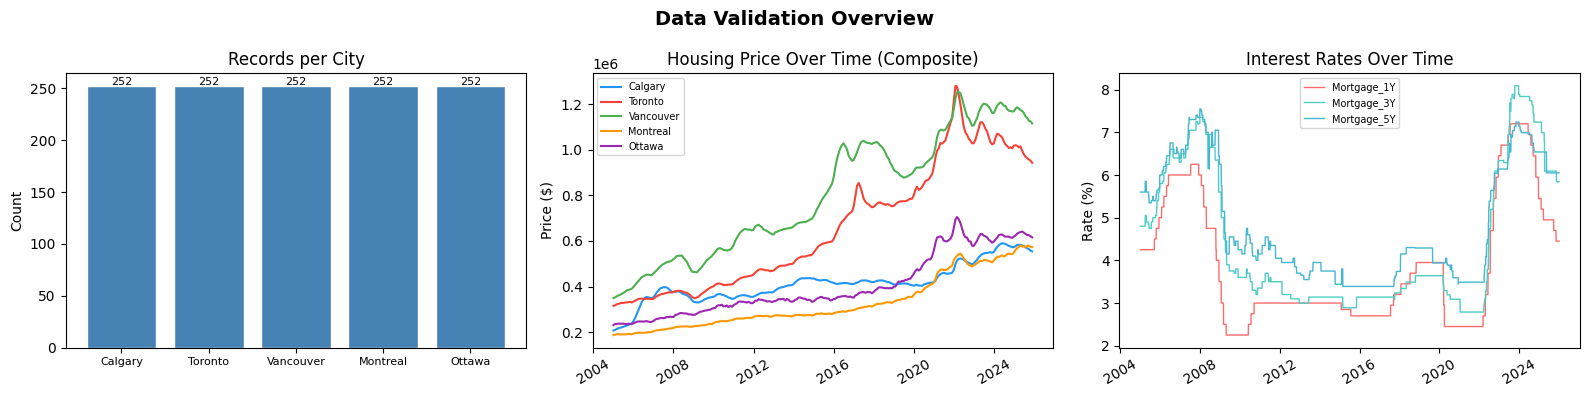

✓ Saved to 03_Results/validation_overview.png


In [23]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle('Data Validation Overview', fontsize=14, fontweight='bold')

# 1. Records per city
city_counts = housing_df['City'].value_counts()
bars = axes[0].bar(range(len(city_counts)), city_counts.values, color='steelblue', edgecolor='white')
axes[0].set_xticks(range(len(city_counts)))
axes[0].set_xticklabels([c.replace('Greater ', '').replace(' CMA', '') for c in city_counts.index], fontsize=8)
axes[0].set_title('Records per City')
axes[0].set_ylabel('Count')
for bar, val in zip(bars, city_counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, val + 1, str(val), ha='center', fontsize=8)

# 2. Composite price over time
colors = ['#2196F3', '#F44336', '#4CAF50', '#FF9800', '#9C27B0']
for i, city in enumerate(housing_df['City'].unique()):
    city_data = housing_df[housing_df['City'] == city].sort_values('Date')
    label = city.replace('Greater ', '').replace(' CMA', '')
    axes[1].plot(city_data['Date'], city_data['Price'], label=label,
                 color=colors[i], linewidth=1.5)
axes[1].set_title('Housing Price Over Time (Composite)')
axes[1].set_ylabel('Price ($)')
axes[1].legend(fontsize=7)
axes[1].tick_params(axis='x', rotation=30)

# 3. Mortgage rates over time
for col, color in zip(['Mortgage_1Y', 'Mortgage_3Y', 'Mortgage_5Y'],
                       ['#FF6B6B', '#4ECDC4', '#45B7D1']):
    axes[2].plot(rates_df['Date'], rates_df[col], label=col, color=color, linewidth=1)
axes[2].set_title('Interest Rates Over Time')
axes[2].set_ylabel('Rate (%)')
axes[2].legend(fontsize=7)
axes[2].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.savefig('../03_Results/validation_overview.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Saved to 03_Results/validation_overview.png')